In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
from tensorflow.keras.metrics import MeanIoU
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import numpy as np
from tqdm import tqdm
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import glob
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.metrics import MeanIoU
from keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, concatenate, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/My Drive/TEST.zip'

destination_folder = '/content/drive/My Drive/extraced/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("Contents of the destination folder after unzipping:")
print(os.listdir(destination_folder))

Contents of the destination folder after unzipping:
['TEST']


In [ ]:
zip_file_path = '/content/drive/My Drive/train_val.zip'

destination_folder = '/content/drive/My Drive/extraced/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("Contents of the destination folder after unzipping:")
print(os.listdir(destination_folder))

Contents of the destination folder after unzipping:
['TEST', 'train_val']


In [ ]:
img = glob.glob('/content/drive/My Drive/extraced/train_val/images/**.jpg')
mask = glob.glob('/content/drive/My Drive/extraced/train_val/masks/**.bmp')

In [ ]:
tranImage = np.zeros((len(img),160,160,3))
tranMask = np.zeros((len(img),160,160,3))
for i in tqdm(range(len(img))):
  original_image = Image.open(img[i])
  target_size = (160, 160)
  resized_image = original_image.resize(target_size, Image.ANTIALIAS)
  name = img[i].split('/')[-1]
  name=name[:-4]+'.bmp'
  original_mask = Image.open('/content/drive/My Drive/extraced/train_val/masks/'+name)
  resized_mask = original_mask.resize(target_size, Image.ANTIALIAS)
  image_array = np.array(resized_image)
  mask_array = np.array(resized_mask)/ 255.0
  tranImage[i]=image_array
  tranMask[i]=mask_array

  0%|          | 0/1373 [00:00<?, ?it/s]<ipython-input-7-2be64676db6b>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = original_image.resize(target_size, Image.ANTIALIAS)
<ipython-input-7-2be64676db6b>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_mask = original_mask.resize(target_size, Image.ANTIALIAS)
100%|██████████| 1373/1373 [18:45<00:00,  1.22it/s]


In [ ]:
img = glob.glob('/content/drive/My Drive/extraced/TEST/images/**.jpg')
mask = glob.glob('/content/drive/My Drive/extraced/TEST/masks/**.bmp')
testImage = np.zeros((len(img),160,160,3))
testMask = np.zeros((len(img),160,160,3))
for i in tqdm(range(len(img))):
  original_image = Image.open(img[i])
  target_size = (160, 160)
  resized_image = original_image.resize(target_size, Image.ANTIALIAS)
  name = img[i].split('/')[-1]
  name=name[:-4]+'.bmp'
  original_mask = Image.open('/content/drive/My Drive/HW3/extraced/TEST/masks/'+name)
  resized_mask = original_mask.resize(target_size, Image.ANTIALIAS)
  image_array = np.array(resized_image)
  mask_array = np.array(resized_mask)/ 255.0
  testImage[i]=image_array
  testMask[i]=mask_array

  0%|          | 0/110 [00:00<?, ?it/s]<ipython-input-8-a1bd7bf8da06>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = original_image.resize(target_size, Image.ANTIALIAS)
<ipython-input-8-a1bd7bf8da06>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_mask = original_mask.resize(target_size, Image.ANTIALIAS)
100%|██████████| 110/110 [01:30<00:00,  1.22it/s]


In [ ]:
img_dir = '/content/drive/My Drive/extraced/train_val/images/'
mask_dir = '/content/drive/My Drive/extraced/train_val/masks/'
new_img_dir = '/content/drive/My Drive/extraced/sample_data/images/'
new_mask_dir = '/content/drive/My Drive/extraced/sample_data/masks/'

images = glob.glob(img_dir + '*.jpg')
masks = glob.glob(mask_dir + '*.bmp')

image_mask_map = defaultdict(list)
for mask_path in masks:
    image_filename = os.path.splitext(os.path.basename(mask_path))[0] + '.jpg'
    image_mask_map[image_filename].append(mask_path)

random.shuffle(images)

num_images_for_eval = int(len(images) * 0.1)

mask_counts = defaultdict(int)
chosen_images = []

for img_path in images:
    img_filename = os.path.basename(img_path)
    if len(chosen_images) < num_images_for_eval:
        masks_for_image = image_mask_map[img_filename]
        should_choose = True
        for mask_path in masks_for_image:
            mask_counts[mask_path] += 1
            if mask_counts[mask_path] > (num_images_for_eval / len(masks)):
                should_choose = False
                break
        if should_choose:
            chosen_images.append(img_path)

os.makedirs(new_img_dir, exist_ok=True)
os.makedirs(new_mask_dir, exist_ok=True)

for img_path in chosen_images:
    img_filename = os.path.basename(img_path)
    mask_filename = os.path.splitext(img_filename)[0] + '.bmp'
    if os.path.exists(os.path.join(mask_dir, mask_filename)):
        shutil.copy(img_path, os.path.join(new_img_dir, img_filename))
        shutil.copy(os.path.join(mask_dir, mask_filename), os.path.join(new_mask_dir, mask_filename))
        os.remove(img_path)
        os.remove(os.path.join(mask_dir, mask_filename))

print("Process completed. Chosen images and masks are copied to the new directories and deleted from the source directories.")

Process completed. Chosen images and masks are copied to the new directories and deleted from the source directories.


In [ ]:
img = glob.glob('/content/drive/My Drive/extraced/sample_data/images/**.jpg')
mask = glob.glob('/content/drive/My Drive/extraced/sample_data/masks/**.bmp')
val_Image = np.zeros((len(img),160,160,3))
val_Mask = np.zeros((len(img),160,160,3))
for i in tqdm(range(len(img))):
  original_image = Image.open(img[i])
  target_size = (160, 160)
  resized_image = original_image.resize(target_size, Image.ANTIALIAS)
  name = img[i].split('/')[-1]
  name=name[:-4]+'.bmp'
  original_mask = Image.open('/content/drive/My Drive/extraced/sample_data/masks/'+name)
  resized_mask = original_mask.resize(target_size, Image.ANTIALIAS)
  image_array = np.array(resized_image)
  mask_array = np.array(resized_mask)/ 255.0
  val_Image[i]=image_array
  val_Mask[i]=mask_array

  0%|          | 0/152 [00:00<?, ?it/s]<ipython-input-4-de3eecc24409>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = original_image.resize(target_size, Image.ANTIALIAS)
<ipython-input-4-de3eecc24409>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_mask = original_mask.resize(target_size, Image.ANTIALIAS)
100%|██████████| 152/152 [02:08<00:00,  1.19it/s]


In [ ]:
tranImage = tranImage.astype(np.uint8)
testImage = testImage.astype(np.uint8)
val_Image = val_Image.astype(np.uint8)

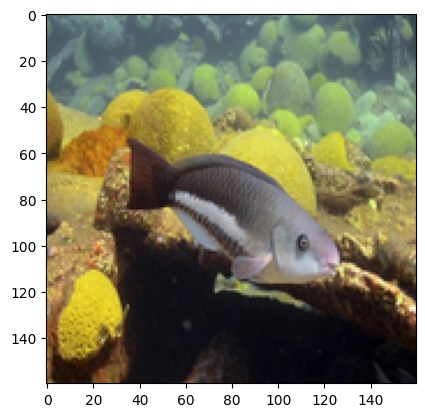

In [ ]:
plt.imshow(tranImage[30])

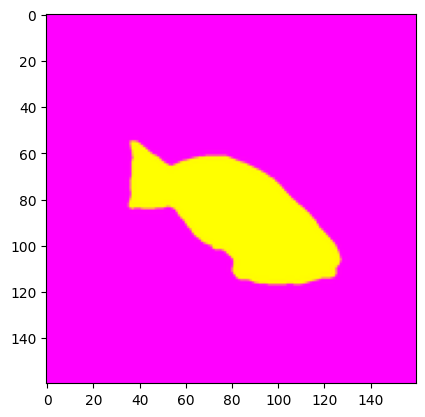

In [ ]:
plt.imshow(tranMask[30])

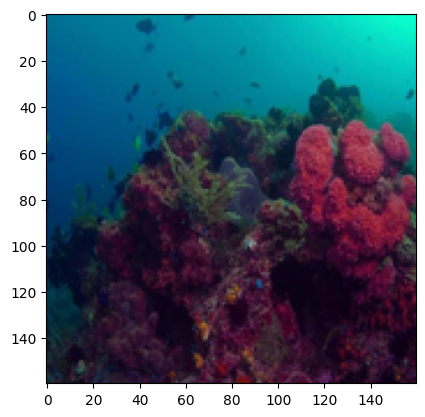

In [ ]:
plt.imshow(testImage[30])

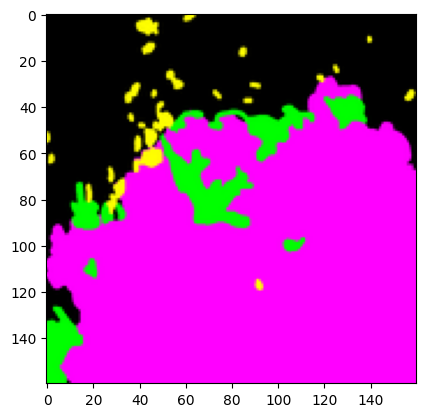

In [ ]:
plt.imshow(testMask[30])

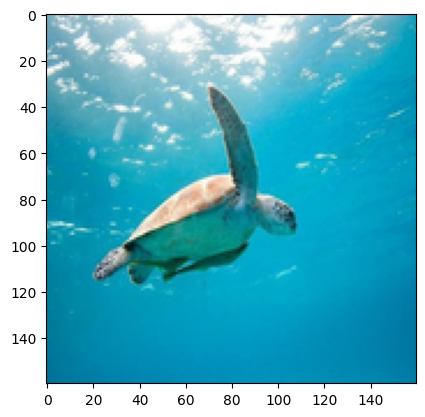

In [ ]:
plt.imshow(val_Image[30])

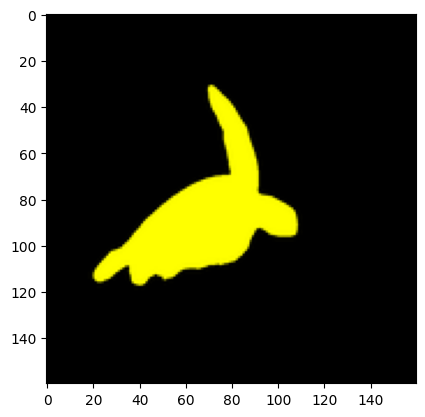

In [ ]:
plt.imshow(val_Mask[30])

In [ ]:
start_index = 0
end_index = 155
X_val = val_Image[start_index:end_index]
y_val = val_Mask[start_index:end_index]
num_samples_train = len(X_val)
print("Number of data samples in X_train:", num_samples_train)

Number of data samples in X_train: 152


In [ ]:
start_index = 0
end_index = 1378
X_train = tranImage[start_index:end_index]
y_train = tranMask[start_index:end_index]
num_samples_train = len(tranImage)
print("Number of data samples in X_train:", num_samples_train)

Number of data samples in X_train: 1373


In [ ]:
data_gen_args = dict(
    rotation_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_gen = ImageDataGenerator(**data_gen_args)
train_gen.fit(X_train)

In [ ]:
def PSPNet(input_size=(160, 160, 3), num_classes=3):
    base_model = MobileNetV2(input_shape=input_size, include_top=False, weights='imagenet')
    x = base_model.output

    # Pyramid Pooling Module
    pool_factors = [1, 2, 3, 6]
    pool_list = [GlobalAveragePooling2D()(x)]
    for p in pool_factors:
        pooled = Lambda(lambda x: tf.image.resize(x, (input_size[0] // p, input_size[1] // p)))(x)
        pooled = Conv2D(256, (1, 1), padding='same', activation='relu')(pooled)
        pool_list.append(GlobalAveragePooling2D()(pooled))
    x = concatenate(pool_list, axis=-1)
    x = Reshape((1, 1, -1))(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D((input_size[0] // 4, input_size[1] // 4))(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(num_classes, (1, 1), padding='same', activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)

    # Freeze MobileNetV2 layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = PSPNet()

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']      

In [ ]:
def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_miou(y_true_list, y_pred_list):
    if len(y_true_list) != len(y_pred_list):
        raise ValueError("Lengths of y_true_list and y_pred_list must be the same.")

    iou_scores = []
    for i in range(len(y_true_list)):
        iou = calculate_iou(y_true_list[i], y_pred_list[i])
        iou_scores.append(iou)

    mIoU = np.mean(iou_scores)
    return mIoU

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
Epoch = 10
batch_size = 32

mean_iou = MeanIoU(num_classes=3)

checkpoint = ModelCheckpoint('pspnet_best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
tensorboard = TensorBoard(log_dir='./logs')

callbacks_list = [checkpoint, tensorboard]

with tf.device('/GPU:0'):
  history = model.fit(
    train_gen.flow(X_train, y_train, batch_size=32),
    epochs=Epoch,
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)

Physical devices cannot be modified after being initialized
<ipython-input-13-26ef0949a807>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=32), epochs=Epoch , steps_per_epoch=int(len(X_train)/32), validation_data=(X_val, y_val),callbacks=callbacks_list)
Epoch 1/10
42/42 [==============================] - ETA: 0s - loss: 1.6187 - accuracy: 0.6932
Epoch 1: val_loss improved from inf to 1.40647, saving model to pspnet_best_model.h5
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
   saving_api.save_model(
42/42 [==============================] - 126s 2s/step - loss: 1.6187 - accuracy: 0.6932 -

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_iou = []
val_iou = []

for i in range(len(X_train)):
    train_pred = model.predict(np.expand_dims(X_train[i], axis=0))
    train_iou.append(calculate_iou(y_train[i], train_pred[0]))

for i in range(len(X_val)):
    val_pred = model.predict(np.expand_dims(X_val[i], axis=0))
    val_iou.append(calculate_iou(y_val[i], val_pred[0]))

1/1 [==============================] - 0s 19ms/step


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_iou = []
val_iou = []

for i in range(len(X_train)):
    train_pred = model.predict(np.expand_dims(X_train[i], axis=0))
    train_iou.append(calculate_iou(y_train[i], train_pred[0]))

for i in range(len(X_val)):
    val_pred = model.predict(np.expand_dims(X_val[i], axis=0))
    val_iou.append(calculate_iou(y_val[i], val_pred[0]))

mean_train_iou = np.mean(train_iou)
mean_val_iou = np.mean(val_iou)

epochs = range(1, len(train_loss) + 1)

1/1 [==============================] - 0s 32ms/step


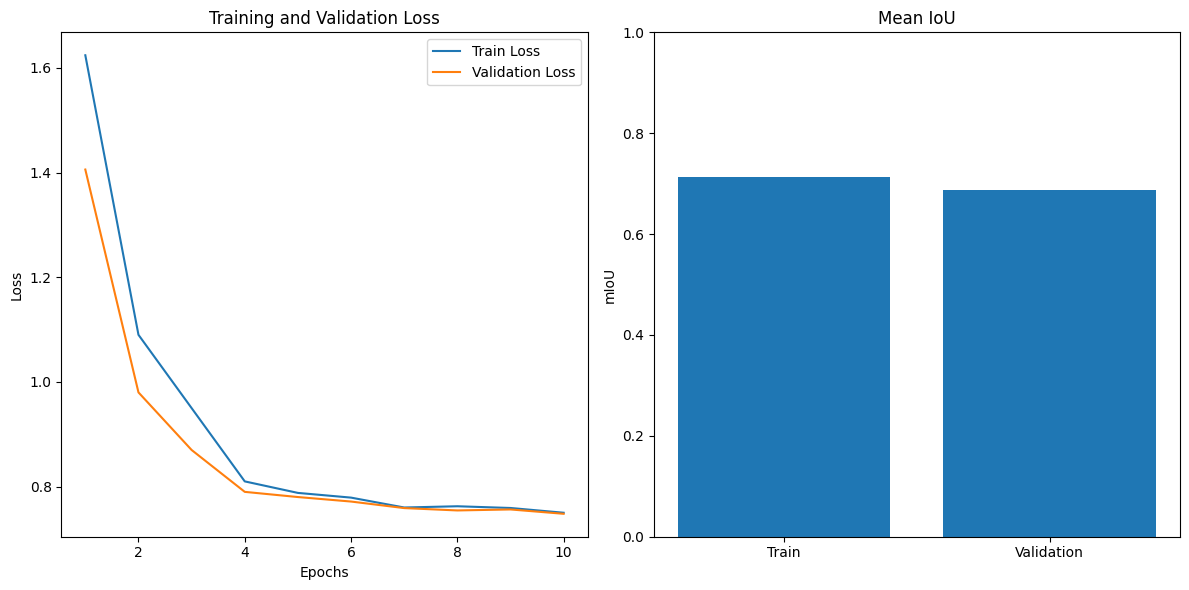

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(['Train', 'Validation'], [mean_train_iou, mean_val_iou])
plt.title('Mean IoU')
plt.ylabel('mIoU')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
best_model = load_model('pspnet_best_model.h5')

def calculate_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

test_iou = []

for i in range(len(testImage)):
    test_pred = best_model.predict(np.expand_dims(testImage[i], axis=0))
    test_iou.append(calculate_iou(testMask[i], test_pred[0]))

mean_iou = np.mean(test_iou)
print(f"Mean Intersection over Union (mIOU) on test data: {mean_iou}")

1/1 [==============================] - 0s 28ms/step
Mean Intersection over Union (mIOU) on test data: 0.69563547896541258


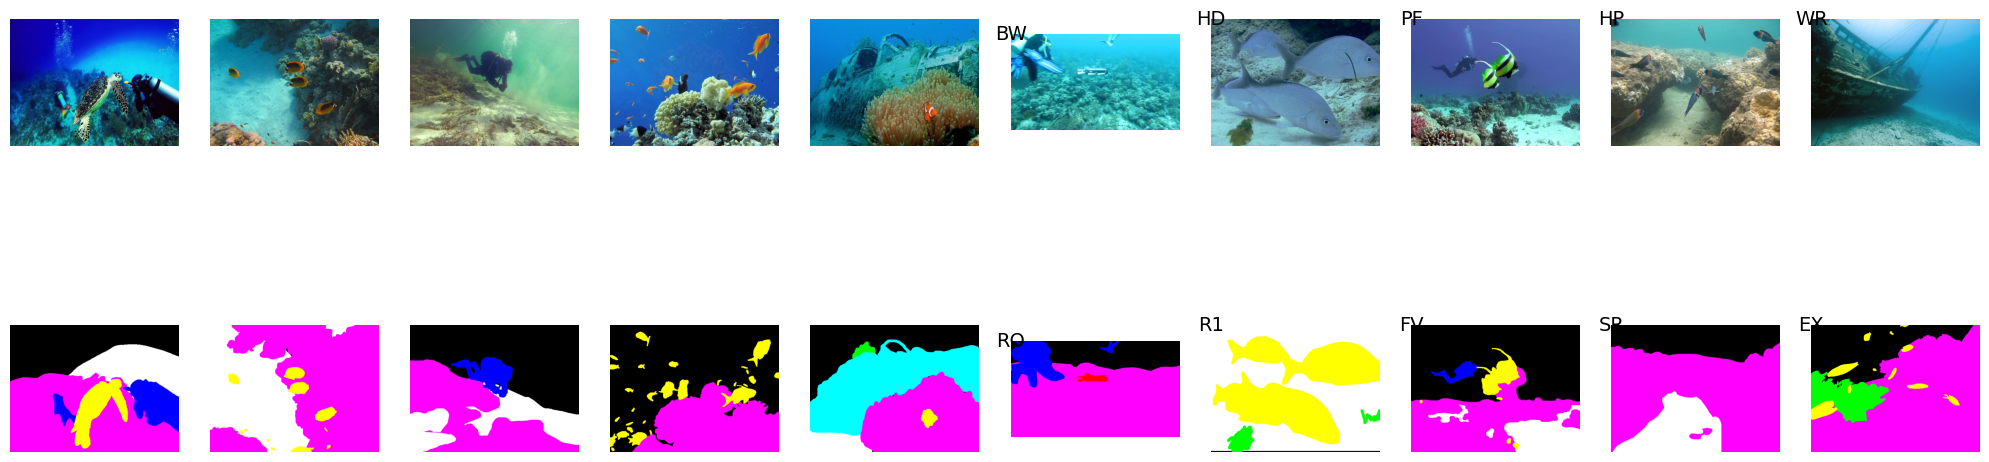

In [ ]:
num_samples = 10
samples_idx = np.random.choice(np.arange(len(_inputs)), num_samples, replace=False)
fig, axes = plt.subplots(3, num_samples, figsize=(1.5 * num_samples, 4.5))

for i, s_idx in enumerate(samples_idx):
    image = _inputs[s_idx]
    pred_mask = class_idx_to_color[_preds[s_idx]]

    image = np.transpose(image, (1, 2, 0))
    image = np.clip(image, 0, 1)

    axes[0, i].imshow(image)
    axes[0, i].axis('off')

    axes[2, i].imshow(pred_mask)
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()